<a href="https://colab.research.google.com/github/summerolmstead/Sales-Prediction/blob/main/Pizza_Sales_ML_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Team Project | Pizza Prediction Sales

Summer, Jason, Victoria, Regan

#Importing Data in

In [68]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("rhonarosecortez/pizza-sales-dataset") #importing from kaggle

print("Path to dataset files:", path) # path to the file

Path to dataset files: /root/.cache/kagglehub/datasets/rhonarosecortez/pizza-sales-dataset/versions/2


In [69]:
import os
dataset_files = os.listdir(path)
print("Dataset files:", dataset_files)

Dataset files: ['Pizza Sales Dataset.csv']


In [70]:
import pandas as pd
csv_file_path = os.path.join(path, 'Pizza Sales Dataset.csv')
df = pd.read_csv(csv_file_path)

print(df.head()) # seeing structure of data

   pizza_id  order_id  pizza_name_id  quantity order_date order_day  \
0         1         1     hawaiian_m         1   1/1/2015  Thursday   
1         2         2  classic_dlx_m         1   1/1/2015  Thursday   
2         3         2  five_cheese_l         1   1/1/2015  Thursday   
3         4         2    ital_supr_l         1   1/1/2015  Thursday   
4         5         2     mexicana_m         1   1/1/2015  Thursday   

  order_time  unit_price  total_price pizza_size pizza_category  \
0   11:38:36       13.25        13.25          M        Classic   
1   11:57:40       16.00        16.00          M        Classic   
2   11:57:40       18.50        18.50          L         Veggie   
3   11:57:40       20.75        20.75          L        Supreme   
4   11:57:40       16.00        16.00          M         Veggie   

                                   pizza_ingredients  \
0           Sliced Ham, Pineapple, Mozzarella Cheese   
1  Pepperoni, Mushrooms, Red Onions, Red Peppers,...   
2 

In [71]:
# Print all unique values in the 'order_day' column
print(df['order_day'].unique())

# Print the first few rows of the dataframe to inspect
print(df.head())

['Thursday' 'Friday' 'Saturday' 'Sunday' 'Monday' 'Tuesday' 'Wednesday']
   pizza_id  order_id  pizza_name_id  quantity order_date order_day  \
0         1         1     hawaiian_m         1   1/1/2015  Thursday   
1         2         2  classic_dlx_m         1   1/1/2015  Thursday   
2         3         2  five_cheese_l         1   1/1/2015  Thursday   
3         4         2    ital_supr_l         1   1/1/2015  Thursday   
4         5         2     mexicana_m         1   1/1/2015  Thursday   

  order_time  unit_price  total_price pizza_size pizza_category  \
0   11:38:36       13.25        13.25          M        Classic   
1   11:57:40       16.00        16.00          M        Classic   
2   11:57:40       18.50        18.50          L         Veggie   
3   11:57:40       20.75        20.75          L        Supreme   
4   11:57:40       16.00        16.00          M         Veggie   

                                   pizza_ingredients  \
0           Sliced Ham, Pineapple, Mozzar

# Basic Check of the Data

In [72]:
df.describe() # seeing summary statistics

,pizza_id,order_id,quantity,unit_price,total_price
count,48620.000000,48620.000000,48620.000000,48620.000000,48620.000000
mean,24310.500000,10701.479761,1.019622,16.494132,16.821474
std,14035.529381,6180.119770,0.143077,3.621789,4.437398
min,1.000000,1.000000,1.000000,9.750000,9.750000
25%,12155.750000,5337.000000,1.000000,12.750000,12.750000
50%,24310.500000,10682.500000,1.000000,16.500000,16.500000
75%,36465.250000,16100.000000,1.000000,20.250000,20.500000
max,48620.000000,21350.000000,4.000000,35.950000,83.000000


# Data Processing

In [73]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from datetime import timedelta

# Preprocess the date-related columns
df['order_date'] = pd.to_datetime(df['order_date'])
df['order_day'] = pd.to_datetime(df['order_day'], format='%A').dt.dayofweek

# Feature engineering for model input
df['month'] = df['order_date'].dt.month
df['day'] = df['order_date'].dt.day
df['year'] = df['order_date'].dt.year
df['weekday'] = df['order_date'].dt.weekday

# **New Step**: Aggregate pizza sales by pizza type and date
pizza_sales_by_day = df.groupby(['order_date', 'pizza_name']).agg(
    total_sales=('total_price', 'sum'),
    total_quantity=('quantity', 'sum'),
    month=('month', 'first'),
    day=('day', 'first'),
    year=('year', 'first'),
    weekday=('weekday', 'first')
).reset_index()

# **New Step**: Create pizza ingredient mapping
pizza_ingredients_map = df.groupby('pizza_name')['pizza_ingredients'].apply(lambda x: ', '.join(x.unique())).to_dict()

# Prepare the feature matrix (X) and target variable (y) for predicting total sales and ingredients
X = pizza_sales_by_day[['month', 'day', 'year', 'weekday', 'total_quantity']]  # including total quantity as a feature
y_sales = pizza_sales_by_day['total_sales']  # Target: total sales

# **New Step**: Prepare ingredient predictions
ingredient_predictions = []

for _, row in pizza_sales_by_day.iterrows():
    pizza_name = row['pizza_name']
    ingredients = pizza_ingredients_map.get(pizza_name, '')
    ingredient_predictions.append({'order_date': row['order_date'], 'pizza_name': pizza_name, 'ingredients': ingredients})

ingredient_df = pd.DataFrame(ingredient_predictions)

# Print the first few rows to verify
print(pizza_sales_by_day.head())
print(ingredient_df.head())

# Train-test split for sales forecasting
X_train, X_test, y_train, y_test = train_test_split(X, y_sales, test_size=0.2, random_state=42)

# Train XGBoost model for total sales forecasting
model_sales = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=1000, max_depth=5, learning_rate=0.01)
model_sales.fit(X_train, y_train)

# Predicting on test data for sales
y_pred_sales = model_sales.predict(X_test)
mae_sales = mean_absolute_error(y_test, y_pred_sales)
print(f'Mean Absolute Error for Sales Prediction: {mae_sales}')

# Forecasting the next 30 days of pizza sales
future_dates = pd.date_range(pizza_sales_by_day['order_date'].max(), periods=31, freq='D')[1:]  # Next 30 days
future_features = pd.DataFrame({
    'month': future_dates.month,
    'day': future_dates.day,
    'year': future_dates.year,
    'weekday': future_dates.weekday,
    'total_quantity': np.zeros(30)  # You can set this to zeros or an estimated value
})

# Predict future sales
future_sales = model_sales.predict(future_features)

# Prepare a DataFrame for the future sales predictions
future_sales_df = pd.DataFrame({
    'order_date': future_dates,
    'predicted_total_sales': future_sales
})

# Display the predicted future sales
print(future_sales_df)

# Step 1: Calculate the historical sales for each pizza type because we want dynamic percentage points
# Assuming you have a DataFrame `pizza_sales_by_day` with 'pizza_name' and 'sales' columns
pizza_sales_by_pizza = pizza_sales_by_day.groupby('pizza_name')['total_sales'].sum()  # Use 'total_sales' column

# Calculate the total sales across all pizzas
total_sales = pizza_sales_by_pizza.sum()

# Now calculate the percentage of total sales for each pizza
pizza_sales_percentage = pizza_sales_by_pizza / total_sales

# Check the calculated percentages for each pizza
print(pizza_sales_percentage)

# Predict ingredients for the future dates
ingredient_predictions_future = []

for date in future_dates:
    # Get the sales forecast for each pizza type
    daily_ingredients = []
    predicted_sales = future_sales_df.loc[future_sales_df['order_date'] == date, 'predicted_total_sales'].values[0]

    # Loop over each pizza in the historical pizza list
    for pizza_name in pizza_ingredients_map:
        # Get the historical sales percentage for this pizza
        pizza_percentage = pizza_sales_percentage.get(pizza_name, 0)  # Default to 0 if not found

        # Predicted sales for this pizza is the historical percentage * predicted total sales
        predicted_sales_for_pizza = pizza_percentage * predicted_sales

        ingredients = pizza_ingredients_map.get(pizza_name, '')
        if ingredients:
            daily_ingredients.append(f"{pizza_name}: {ingredients} ({pizza_percentage:.2%} of sales, {predicted_sales_for_pizza:.2f} sales)")

    ingredient_predictions_future.append({'date': date, 'ingredients': ', '.join(daily_ingredients)})

# Create a DataFrame to view the ingredient predictions for future dates
ingredient_df_future = pd.DataFrame(ingredient_predictions_future)

# Display the predicted ingredients
print(ingredient_df_future)



  order_date                    pizza_name  total_sales  total_quantity  \
0 2015-01-01    The Barbecue Chicken Pizza       204.25              11   
1 2015-01-01            The Big Meat Pizza        60.00               5   
2 2015-01-01           The Calabrese Pizza        16.25               1   
3 2015-01-01  The California Chicken Pizza        71.00               4   
4 2015-01-01     The Chicken Alfredo Pizza        29.50               2   

   month  day  year  weekday  
0      1    1  2015        3  
1      1    1  2015        3  
2      1    1  2015        3  
3      1    1  2015        3  
4      1    1  2015        3  
  order_date                    pizza_name  \
0 2015-01-01    The Barbecue Chicken Pizza   
1 2015-01-01            The Big Meat Pizza   
2 2015-01-01           The Calabrese Pizza   
3 2015-01-01  The California Chicken Pizza   
4 2015-01-01     The Chicken Alfredo Pizza   

                                         ingredients  
0  Barbecued Chicken, Red Peppe

In [74]:
# Check the columns of future_sales_df to see if the date information is already in a single column
print(future_sales_df.columns)


Index(['order_date', 'predicted_total_sales'], dtype='object')


In [75]:
# Convert 'order_date' column to datetime format
future_sales_df['order_date'] = pd.to_datetime(future_sales_df['order_date'])
# Merge sales data with ingredient predictions for future dates (e.g., January 2016)
merged_df = pd.merge(future_sales_df[['order_date', 'predicted_total_sales']], ingredient_df_future, left_on='order_date', right_on='date', how='left')

# Drop the 'date' column since it's redundant after merging
merged_df = merged_df.drop(columns=['date'])

# Display the merged data (sales and ingredient predictions)
print(merged_df)

   order_date  predicted_total_sales  \
0  2016-01-01              16.457306   
1  2016-01-02              17.078238   
2  2016-01-03              17.241665   
3  2016-01-04              17.596844   
4  2016-01-05              17.062735   
5  2016-01-06              16.812227   
6  2016-01-07              16.944792   
7  2016-01-08              17.447889   
8  2016-01-09              17.141348   
9  2016-01-10              17.286516   
10 2016-01-11              17.622200   
11 2016-01-12              17.200832   
12 2016-01-13              17.159498   
13 2016-01-14              17.345661   
14 2016-01-15              17.256056   
15 2016-01-16              17.266672   
16 2016-01-17              17.484791   
17 2016-01-18              17.770069   
18 2016-01-19              17.391609   
19 2016-01-20              17.666948   
20 2016-01-21              17.644508   
21 2016-01-22              17.622543   
22 2016-01-23              17.653316   
23 2016-01-24              17.498260   


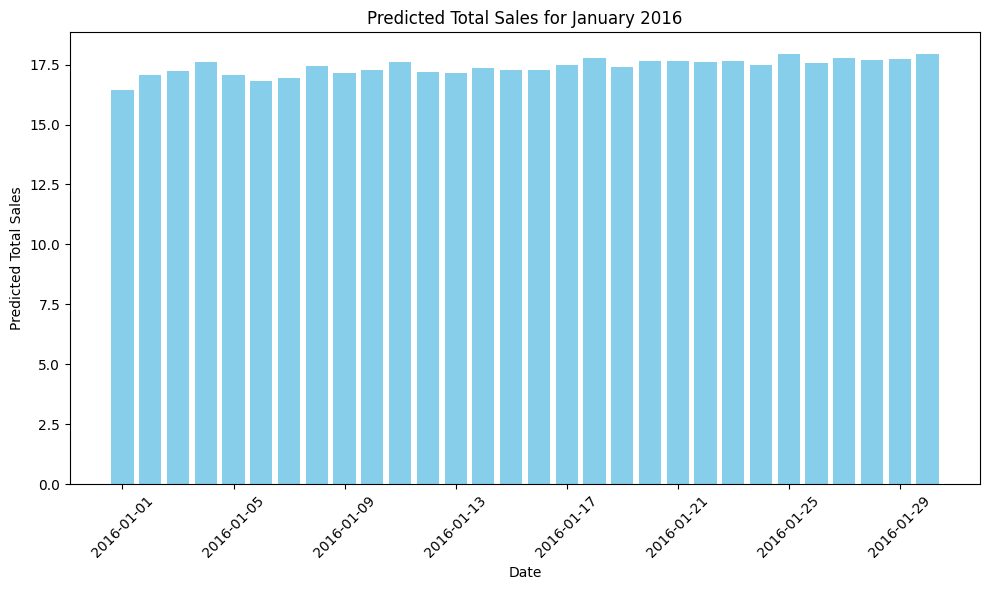

In [76]:
import matplotlib.pyplot as plt

# Plot predicted sales for January 2016
plt.figure(figsize=(10, 6))
plt.bar(merged_df['order_date'], merged_df['predicted_total_sales'], color='skyblue')
plt.xlabel('Date')
plt.ylabel('Predicted Total Sales')
plt.title('Predicted Total Sales for January 2016')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [77]:
# Display a table of ingredients for the corresponding pizzas
print(merged_df[['order_date', 'ingredients']])


   order_date                                        ingredients
0  2016-01-01  The Barbecue Chicken Pizza: Barbecued Chicken,...
1  2016-01-02  The Barbecue Chicken Pizza: Barbecued Chicken,...
2  2016-01-03  The Barbecue Chicken Pizza: Barbecued Chicken,...
3  2016-01-04  The Barbecue Chicken Pizza: Barbecued Chicken,...
4  2016-01-05  The Barbecue Chicken Pizza: Barbecued Chicken,...
5  2016-01-06  The Barbecue Chicken Pizza: Barbecued Chicken,...
6  2016-01-07  The Barbecue Chicken Pizza: Barbecued Chicken,...
7  2016-01-08  The Barbecue Chicken Pizza: Barbecued Chicken,...
8  2016-01-09  The Barbecue Chicken Pizza: Barbecued Chicken,...
9  2016-01-10  The Barbecue Chicken Pizza: Barbecued Chicken,...
10 2016-01-11  The Barbecue Chicken Pizza: Barbecued Chicken,...
11 2016-01-12  The Barbecue Chicken Pizza: Barbecued Chicken,...
12 2016-01-13  The Barbecue Chicken Pizza: Barbecued Chicken,...
13 2016-01-14  The Barbecue Chicken Pizza: Barbecued Chicken,...
14 2016-01-15  The Barbec

In [79]:
# Display the first row of ingredients without truncation
print(merged_df.iloc[0])


order_date                                             2016-01-01 00:00:00
predicted_total_sales                                            16.457306
ingredients              The Barbecue Chicken Pizza: Barbecued Chicken,...
Name: 0, dtype: object
